<a href="https://colab.research.google.com/github/SanjidaJahanTanha/Pneumonia-/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install required libraries
!pip install tensorflow keras opencv-python-headless pydicom matplotlib
import pandas as pd
import os
import pydicom
import matplotlib.pyplot as plt



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.2 MB/s eta 0:00:00


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
# Set the path to the dataset
data_path = '/content/drive/MyDrive/rsna_pneumonia/'

In [5]:
#  Load and Filter the CSV Files
import pandas as pd
import os

# Load the CSV files
train_labels = pd.read_csv('/content/drive/MyDrive/rsna_pneumonia/stage_2_train_labels.csv')

# Get the list of available images
available_images = os.listdir('/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images')
available_image_ids = [os.path.splitext(image)[0] for image in available_images]

# Filter the train_labels DataFrame to include only available images
train_labels_filtered = train_labels[train_labels['patientId'].isin(available_image_ids)]


In [ ]:
# # Display the first few rows of the dataframes
# print("Train Labels:")
# print(train_labels.head())

# print("\nDetailed Class Info:")
# print(detailed_class_info.head())

In [6]:
# Display the first few rows of the dataframes
print("Train Labels:")
print(train_labels.head())

# Calculate class distribution (assuming 'Target' is the column with class labels)
detailed_class_info = train_labels['Target'].value_counts()

print("\nDetailed Class Info:")
print(detailed_class_info)

Train Labels:
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

Detailed Class Info:
Target
0    20672
1     9555
Name: count, dtype: int64


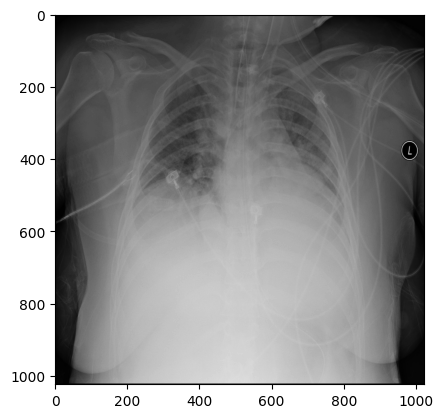

In [ ]:
# Load and display a sample DICOM image
sample_image_path = os.path.join(data_path, 'stage_2_train_images', '00436515-870c-4b36-a041-de91049b9ab4.dcm')
dicom_image = pydicom.dcmread(sample_image_path)
plt.imshow(dicom_image.pixel_array, cmap=plt.cm.gray)
plt.show()


In [7]:
# Handle NaN values and convert bounding boxes
def preprocess_labels(train_labels):
    train_labels = train_labels.fillna(0)
    train_labels['xmax'] = train_labels['x'] + train_labels['width']
    train_labels['ymax'] = train_labels['y'] + train_labels['height']
    train_labels = train_labels[['patientId', 'x', 'y', 'xmax', 'ymax', 'Target']]
    return train_labels

train_labels_processed = preprocess_labels(train_labels_filtered)
print("Processed Train Labels:")
print(train_labels_processed.head())


Processed Train Labels:
                              patientId      x      y   xmax   ymax  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0    0.0       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0    0.0       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0    0.0       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0    0.0       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  477.0  531.0       1


In [8]:
#Import Required Libraries
import os
import pydicom
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [9]:
# Define the Dataset Class
class RSNAPneumoniaDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, image_dir, transforms=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.annotations.iloc[idx, 0] + '.dcm')
        dicom_image = pydicom.dcmread(img_path)
        image = dicom_image.pixel_array.astype(np.float32)
        image = np.stack([image] * 3, axis=-1)  # convert to 3 channels

        boxes = self.annotations.iloc[idx, 1:5].values.astype(np.float32).reshape(-1, 4)
        labels = self.annotations.iloc[idx, 5].astype(np.int64)

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor([labels], dtype=torch.int64)
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

In [10]:
# Create a Subset of Annotations
# Assuming `train_labels_processed` is your DataFrame containing annotations
# Select a random subset of 500 annotations
subset_size = 500  # Adjust this number as needed
subset_annotations = train_labels_processed.sample(n=subset_size, random_state=42).reset_index(drop=True)


In [11]:
# Define transforms
transform = T.Compose([T.ToTensor()])

# Define the path to your image directory
image_dir = '/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images'

# Create a subset of annotations
subset_size = 50  # Adjust as needed
train_subset_annotations = train_labels_processed.sample(n=subset_size, random_state=42).reset_index(drop=True)

# Define dataset and data loader
subset_dataset = RSNAPneumoniaDataset(train_subset_annotations, image_dir, transforms=transform)
subset_data_loader = DataLoader(subset_dataset, batch_size=4, shuffle=True, num_workers=2)


In [12]:
# Define Faster R-CNN Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 2  # 1 class (pneumonia) + background
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 139MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
# Define the train_model function
def train_model(model, data_loader, device, num_epochs=10):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)

            # Debug: Print the targets to understand their structure
            print(f"Raw Targets: {targets}")

            # Ensure targets are dictionaries with the correct structure
            try:
                targets = [{k: (v.to(device) if isinstance(v, torch.Tensor) else torch.tensor(v).to(device)) for k, v in t.items()} for t in targets]
            except AttributeError as e:
                print(f"AttributeError: {e}")
                print(f"Targets: {targets}")
                continue

            # Debug: Print the processed targets
            print(f"Processed Targets: {targets}")

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

        lr_scheduler.step()
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(data_loader)}")

    return model

In [ ]:
# # Move model to device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [14]:
# Train the model
num_epochs = 10  # Adjust the number of epochs as needed
trained_model = train_model(model, subset_data_loader, device, num_epochs=num_epochs)


Raw Targets: {'boxes': tensor([[[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]]]), 'labels': tensor([[0],
        [0],
        [0],
        [0]])}
AttributeError: 'str' object has no attribute 'items'
Targets: {'boxes': tensor([[[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 0.]]]), 'labels': tensor([[0],
        [0],
        [0],
        [0]])}
Raw Targets: {'boxes': tensor([[[  0.,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,   0.]],

        [[590., 365., 834., 607.]]]), 'labels': tensor([[0],
        [0],
        [0],
        [1]])}
AttributeError: 'str' object has no attribute 'items'
Targets: {'boxes': tensor([[[  0.,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,   0.]],

        [[590., 365., 834., 607.]]]), 'labels': tensor([[0],
        [0],
        [0],
        [1]])}
Raw Targets: {'boxes

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Raw Targets: {'boxes': tensor([[[  0.,   0.,   0.,   0.]],

        [[688., 292., 828., 417.]],

        [[  0.,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,   0.]]]), 'labels': tensor([[0],
        [1],
        [0],
        [0]])}
AttributeError: 'str' object has no attribute 'items'
Targets: {'boxes': tensor([[[  0.,   0.,   0.,   0.]],

        [[688., 292., 828., 417.]],

        [[  0.,   0.,   0.,   0.]],

        [[  0.,   0.,   0.,   0.]]]), 'labels': tensor([[0],
        [1],
        [0],
        [0]])}
Raw Targets: {'boxes': tensor([[[  0.,   0.,   0.,   0.]],

        [[514., 354., 753., 856.]],

        [[  0.,   0.,   0.,   0.]],

        [[170., 465., 418., 746.]]]), 'labels': tensor([[0],
        [1],
        [0],
        [1]])}
AttributeError: 'str' object has no attribute 'items'
Targets: {'boxes': tensor([[[  0.,   0.,   0.,   0.]],

        [[514., 354., 753., 856.]],

        [[  0.,   0.,   0.,   0.]],

        [[170., 465., 418., 746.]]]), 'labels': tensor([[0

In [15]:
# Visualization function
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def visualize_predictions(model, data_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            if i >= num_images:
                break
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for j, image in enumerate(images):
                image = image.permute(1, 2, 0).cpu().numpy()
                boxes = outputs[j]['boxes'].cpu().numpy().astype(int)
                labels = outputs[j]['labels'].cpu().numpy()

                fig, ax = plt.subplots(1, 1, figsize=(12, 9))
                ax.imshow(image)

                for box, label in zip(boxes, labels):
                    if label == 1:  # Assuming label 1 is pneumonia
                        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='red')
                        ax.add_patch(rect)
                        ax.text(box[0], box[1], 'Pneumonia', color='red', fontsize=12)

                plt.show()


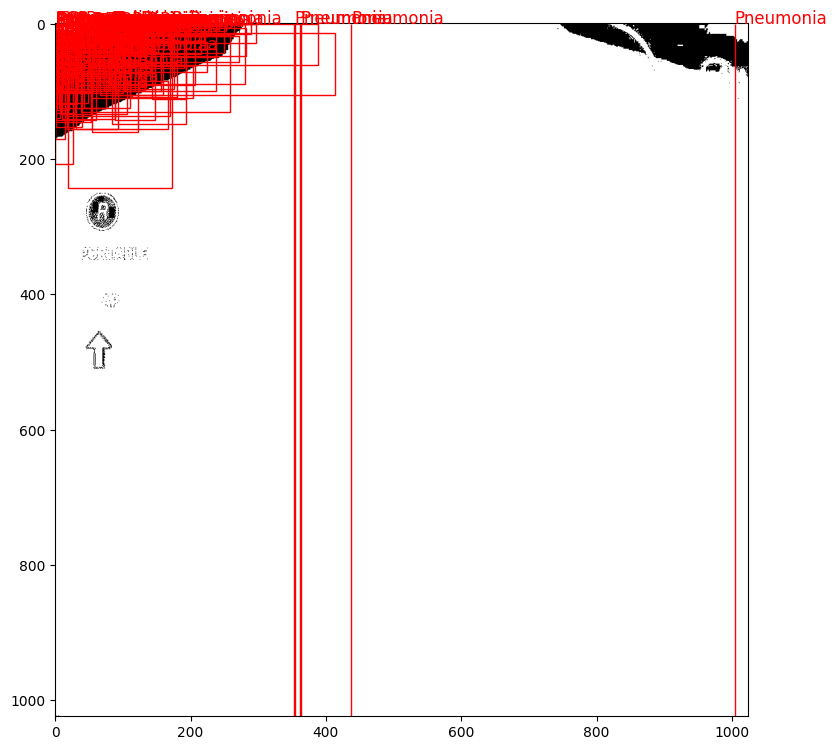

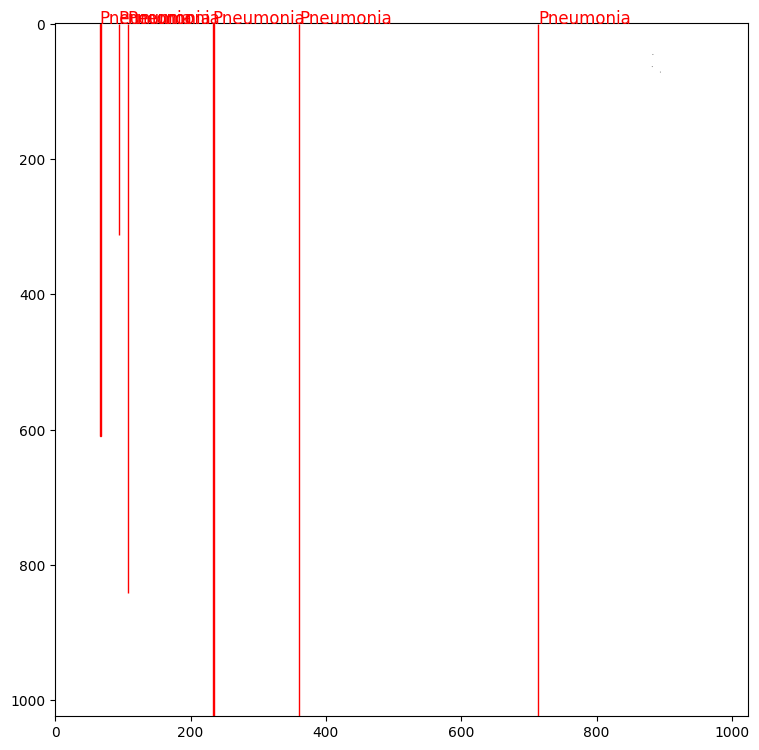

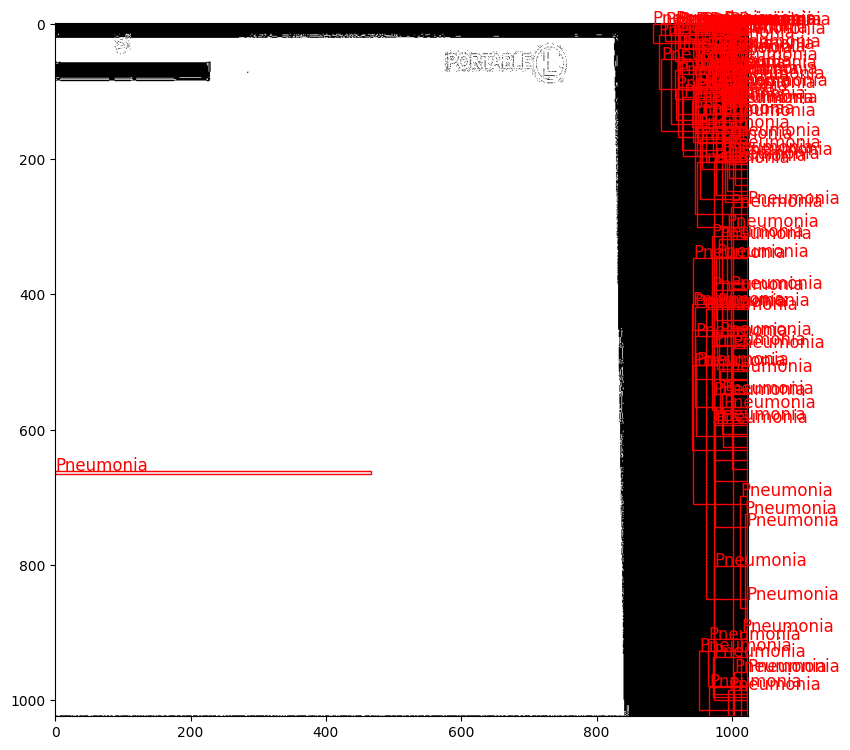

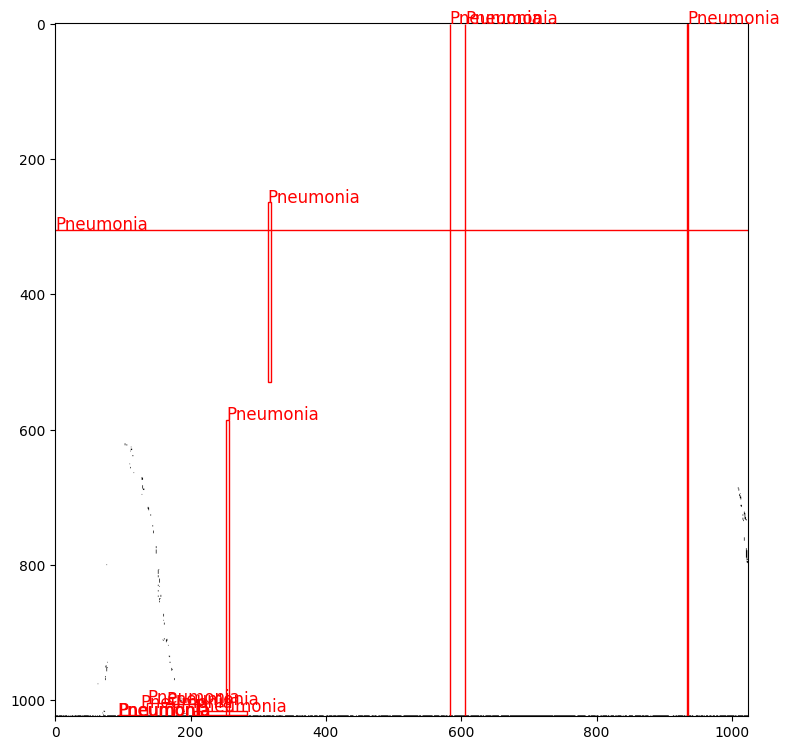

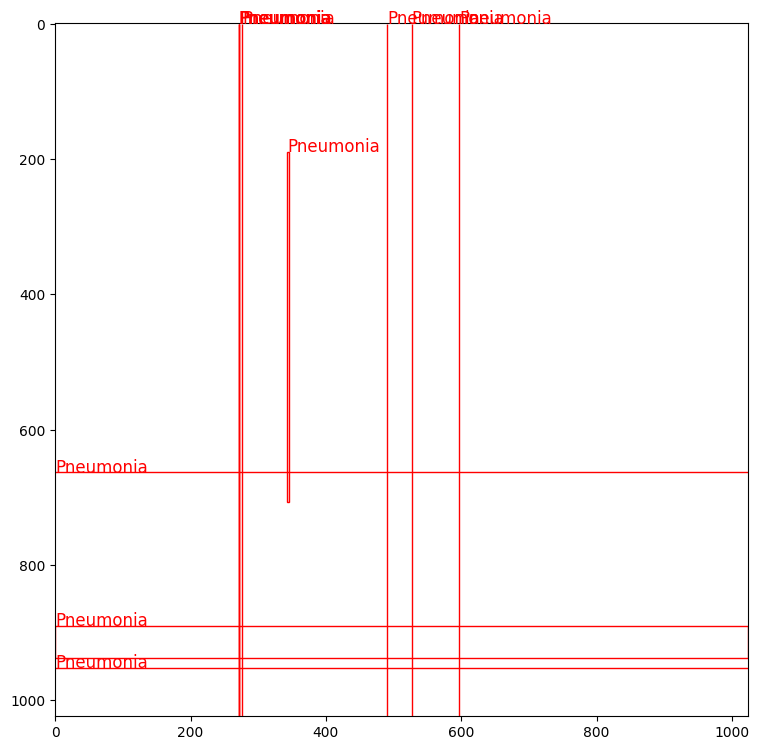

In [16]:
# Define a small validation set
val_subset_size = 20  # Adjust as needed
val_subset_annotations = train_labels_processed.sample(n=val_subset_size, random_state=42).reset_index(drop=True)

# Define the validation dataset and data loader
val_dataset = RSNAPneumoniaDataset(val_subset_annotations, image_dir, transforms=transform)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=2)

# Visualize predictions on the validation set
visualize_predictions(trained_model, val_data_loader, device, num_images=5)

In [ ]:
# #Check Distribution of Labels

# import matplotlib.pyplot as plt

# # Check the distribution of the Target labels
# label_counts = train_labels_processed['Target'].value_counts()
# print("Distribution of Target labels:")
# print(label_counts)

# # Plot the distribution
# label_counts.plot(kind='bar')
# plt.xlabel('Target')
# plt.ylabel('Count')
# plt.title('Distribution of Target labels')
# plt.show()


In [ ]:
# #Visualize a Sample
# import matplotlib.patches as patches
# import numpy as np

# def visualize_sample(dataset, idx):
#     image, target = dataset[idx]
#     image = image.squeeze().numpy()

#     fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#     ax.imshow(image, cmap='gray')

#     for box in target['boxes']:
#         xmin, ymin, xmax, ymax = box
#         width = xmax - xmin
#         height = ymax - ymin
#         rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)

#     plt.show()

# # Visualize a sample from the dataset
# visualize_sample(RSNAPneumoniaDataset, 0)
